In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
imgs_path="/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"
file_path="../input/siim-isic-melanoma-classification/train.csv"

In [13]:
import pandas as pd
import numpy as np
from PIL import Image
import os

In [14]:
file=pd.read_csv(file_path)
file.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [15]:
file['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [16]:
file=file.sort_values(by=['target'],ascending=False)

In [17]:
file.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
9561,ISIC_2967024,IP_6074542,male,70.0,torso,melanoma,malignant,1
32400,ISIC_9785077,IP_8039328,female,35.0,head/neck,melanoma,malignant,1
11048,ISIC_3408231,IP_3034671,male,65.0,head/neck,melanoma,malignant,1
4959,ISIC_1589997,IP_3010556,male,75.0,upper extremity,melanoma,malignant,1
30339,ISIC_9164054,IP_1633296,male,75.0,torso,melanoma,malignant,1


In [18]:
file['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [19]:
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [20]:
data=[]
labels=[]
for i in range(0,2000):
    img_name=str(file.iloc[i,0])+'.jpg'
    labels.append(file.iloc[i,7])
    img=imgs_path+img_name
    image = load_img(img, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    if i%50 == 0:
        print(i,end=' ')

0 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 

In [34]:
X_train,X_val, y_train, y_val=train_test_split(data,labels,test_size=0.2,shuffle=True)

In [35]:
np.array(X_train).shape,np.array(X_val).shape,np.array(y_train).shape,np.array(y_val).shape

((1600, 224, 224, 3), (400, 224, 224, 3), (1600,), (400,))

In [36]:
y_val.count(0),y_val.count(1)

(288, 112)

In [37]:
y_train.count(0),y_val.count(1)

(1128, 112)

In [39]:
# train_data = np.array(X_train, dtype="float32")
# train_labels = np.array(y_train)
# val_data = np.array(X_val, dtype="float32")
# val_labels = np.array(y_val)

In [40]:
# labels.count(1)

In [67]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [73]:
INIT_LR = 1e-3
EPOCHS = 60
BS = 20

In [74]:
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

In [75]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [76]:

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [77]:
H = model.fit(aug.flow(np.array(X_train, dtype="float32"), np.array(y_train), batch_size=BS),
              steps_per_epoch=len(X_train) //(6* BS),
              validation_data=(np.array(X_val, dtype="float32"),np.array(y_val)),
              validation_steps=len(X_val) // (6*BS),
              epochs=EPOCHS)

Epoch 1/60
13/13 [==============================] - 6s 428ms/step - loss: 0.7611 - accuracy: 0.6462 - val_loss: 5.3068 - val_accuracy: 0.7200
Epoch 2/60
13/13 [==============================] - 4s 329ms/step - loss: 0.6588 - accuracy: 0.6962 - val_loss: 3.5134 - val_accuracy: 0.7200
Epoch 3/60
13/13 [==============================] - 4s 296ms/step - loss: 0.5281 - accuracy: 0.6769 - val_loss: 2.8607 - val_accuracy: 0.7200
Epoch 4/60
13/13 [==============================] - 4s 295ms/step - loss: 0.5053 - accuracy: 0.7462 - val_loss: 4.8562 - val_accuracy: 0.7200
Epoch 5/60
13/13 [==============================] - 4s 329ms/step - loss: 0.4610 - accuracy: 0.7769 - val_loss: 3.4126 - val_accuracy: 0.7200
Epoch 6/60
13/13 [==============================] - 4s 290ms/step - loss: 0.4355 - accuracy: 0.8000 - val_loss: 1.1124 - val_accuracy: 0.7200
Epoch 7/60
13/13 [==============================] - 4s 318ms/step - loss: 0.4209 - accuracy: 0.8154 - val_loss: 1.8551 - val_accuracy: 0.7200
Epoch 

13/13 [==============================] - 4s 337ms/step - loss: 0.3989 - accuracy: 0.8000 - val_loss: 0.6387 - val_accuracy: 0.7825
Epoch 59/60
13/13 [==============================] - 4s 296ms/step - loss: 0.3683 - accuracy: 0.8423 - val_loss: 1.5078 - val_accuracy: 0.7550
Epoch 60/60
13/13 [==============================] - 4s 316ms/step - loss: 0.3717 - accuracy: 0.8462 - val_loss: 2.5408 - val_accuracy: 0.7400


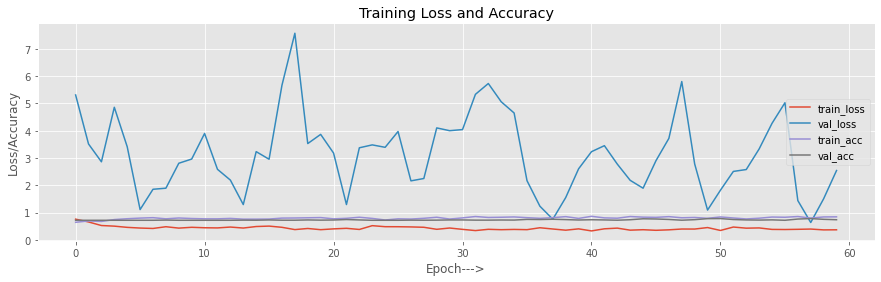

In [78]:
from matplotlib import pyplot as plt

N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(15,4))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch--->")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

In [ ]:
model.save('model.h5')